# Analysis of ATM activities in Argentina

### About the data set

This dataset provides information about the telecommunication activity over the city of Milano.

The dataset is the result of a computation over the Call Detail Records (CDRs) generated by a telco company cellular network over the city of Milano. CDRs log the user activity for billing purposes and network management. There are many types of CDRs, for the generation of this dataset we considered those related to the following activities:

    - Received SMS: a CDR is generated each time a user receives an SMS
    - Sent SMS: a CDR is generated each time a user sends an SMS
    - Incoming Calls: a CDR is generated each time a user receives a call
    - Outgoing Calls: CDR is generated each time a user issues a call
    - Internet: a CDR is generate each time
        - a user starts an internet connection
        - a user ends an internet connection
        - during the same connection one of the following limits is reached:​
            - 15 minutes from the last generated CDR
            - 5 MB from the last generated CDR

By aggregating the aforementioned records it was created this dataset that provides SMSs, calls and Internet traffic activity. It measures the level of interaction of the users with the mobile phone network; for example the higher is the number of SMS sent by the users, the higher is the activity of the sent SMS. Measurements of call and SMS activity have the same scale (therefore are comparable); those referring to Internet traffic do not. 

### Libraries importing

In [1]:
# import pyspark.sql.functions as func
# from pyspark.sql.types import *
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#!pip install <library>

### Credentials for accessing files in Object Storage

In [3]:
# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_aa816606(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', '37ef207335594d13ab057421343b750e')
    hconf.set(prefix + '.username', '764d9f481c0e462ebb661d83eaed0397')
    hconf.set(prefix + '.password', 'EQTbS)(&cj=Ld763')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_aa816606(name)

spark = SparkSession.builder.getOrCreate()

In [4]:
df_data_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://BCPPER.' + name + '/GEO_LOC_CITIES.csv').cache()

In [5]:
df_data_1.show(5)

+-----------+----------+----------+
|  localidad|       lat|       lon|
+-----------+----------+----------+
|rio segundo|-31.650785|-63.905846|
| loma negra|-34.209690|-60.728348|
|san vicente|-26.995216|-54.485780|
|   san juan|-31.535107|-68.538600|
|   macachin|-37.137123|-63.667070|
+-----------+----------+----------+
only showing top 5 rows



In [6]:
df_data_2 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://BCPPER.' + name + '/ATM_ACTIVITIES_JAN_FEB_16_5.csv').cache()

In [7]:
df_data_3 = df_data_2.groupBy(df_data_2.localidad).count().join(df_data_1, df_data_2.localidad == df_data_1.localidad)\
.select(df_data_1.localidad,'count','lat','lon').orderBy('count').limit(100).toPandas()

In [8]:
lats = [float(item) for item in df_data_3.lat]
lons = [float(item) for item in df_data_3.lon]
mag = [float(item) for item in df_data_3['count']]

In [9]:
import folium
from folium import plugins

schools_heatmap = folium.Map(location=[-34.418876, -60.042412], zoom_start=5)
schools_heatmap.add_child(plugins.HeatMap(zip(lats, lons, mag), radius = 15))
schools_heatmap

In [10]:
df_data_4 = df_data_2.groupBy('descr').count().orderBy('count',ascending=False).limit(4).toPandas()

In [11]:
df_data_4

,descr,count
0,extraccion,554707
1,transferencia,443242
2,deposito,54694
3,pago de servicio,29038


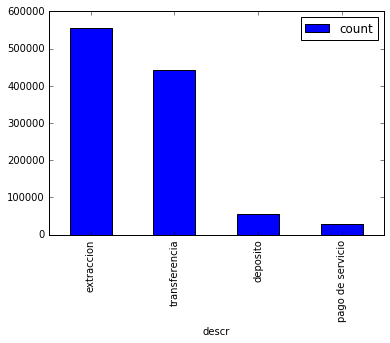

In [18]:
df_data_4.plot(x='descr', y='count', kind='bar')


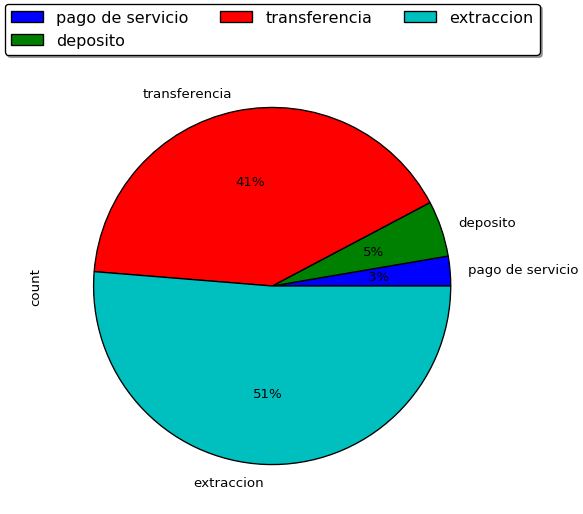

In [13]:
import pixiedust
display(df_data_4)

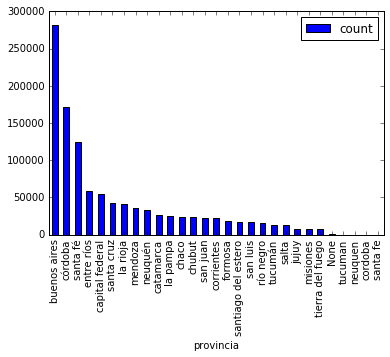

In [17]:
df_data_2.groupBy('provincia').count().orderBy('count',ascending=False).toPandas().plot(x='provincia', y='count', kind='bar')